In [18]:
import phate
import scprep
import seaborn as sns
import os
import json
from PIL import Image, ImageDraw
import re
import numpy as np
import cv2
import imageio
import matplotlib.pyplot as plt
import tifffile as tiff
from tqdm import tqdm
from skimage.exposure import equalize_adapthist
from scipy.stats import stats
import matplotlib.animation as animation
import pandas as pd
import csv
import shutil
from skimage.morphology import dilation, erosion
import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage import measure
from skimage.measure import regionprops, label
from scipy.spatial import distance
import time
import datetime
from mpl_toolkits.mplot3d import Axes3D  # 3D Plotting
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, r2_score

import seaborn as sns
from scipy.ndimage import center_of_mass
from glob import glob
import random
import imageio.v2 as imageio
from tifffile import imread


# LATEST 2-D PCA and Cluster Analysis, Box-Plot by Clusters

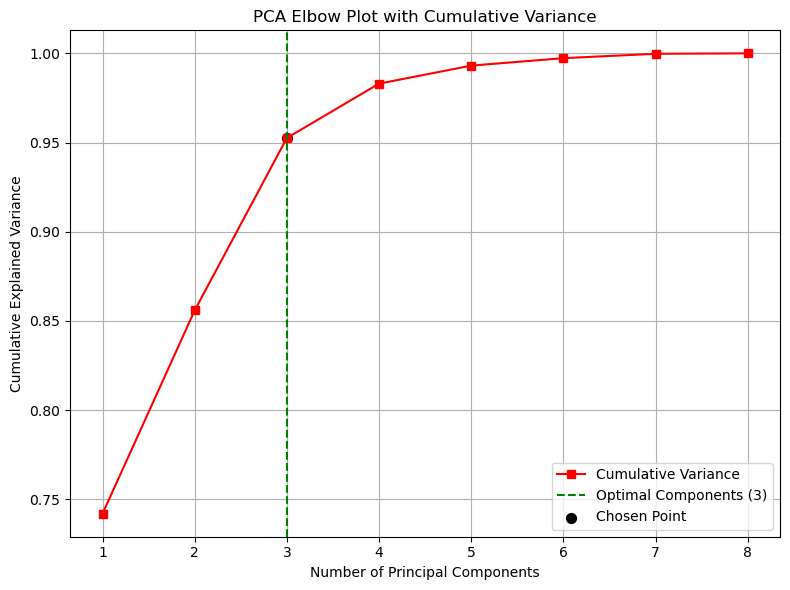

Optimal number of PCA components selected: 3


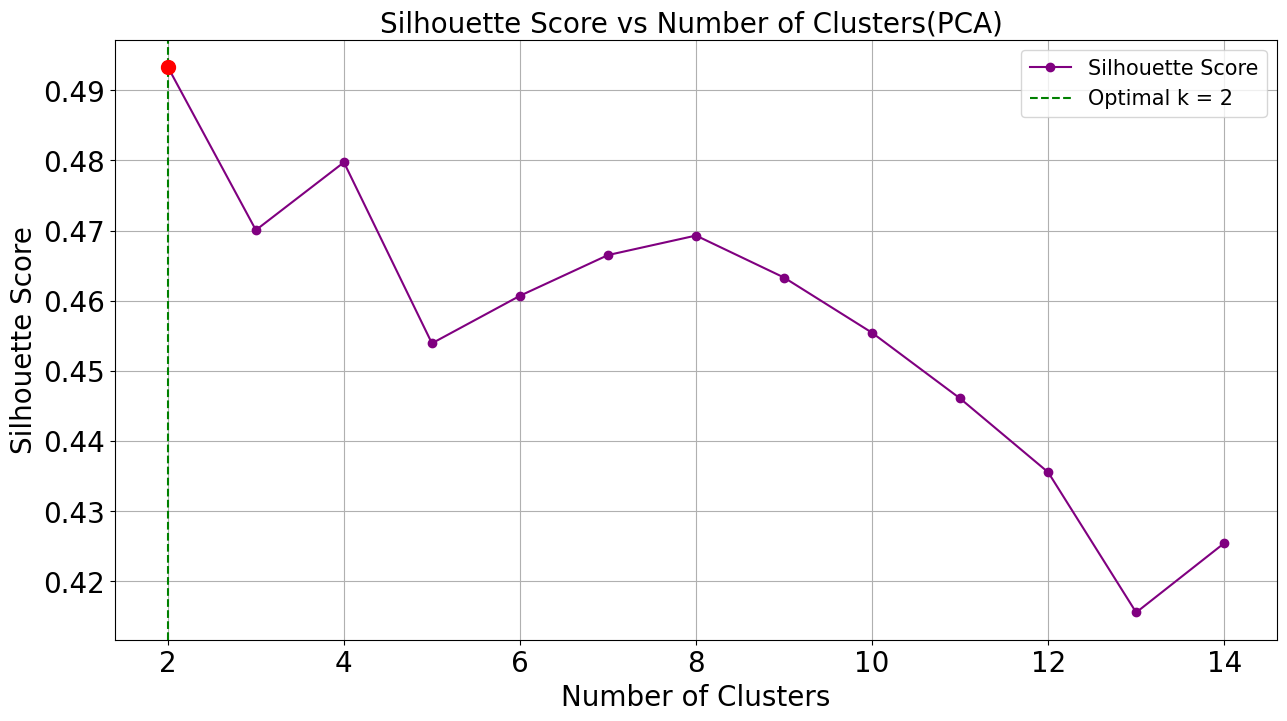

/tmp/ipykernel_3695783/462869339.py:127: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1],


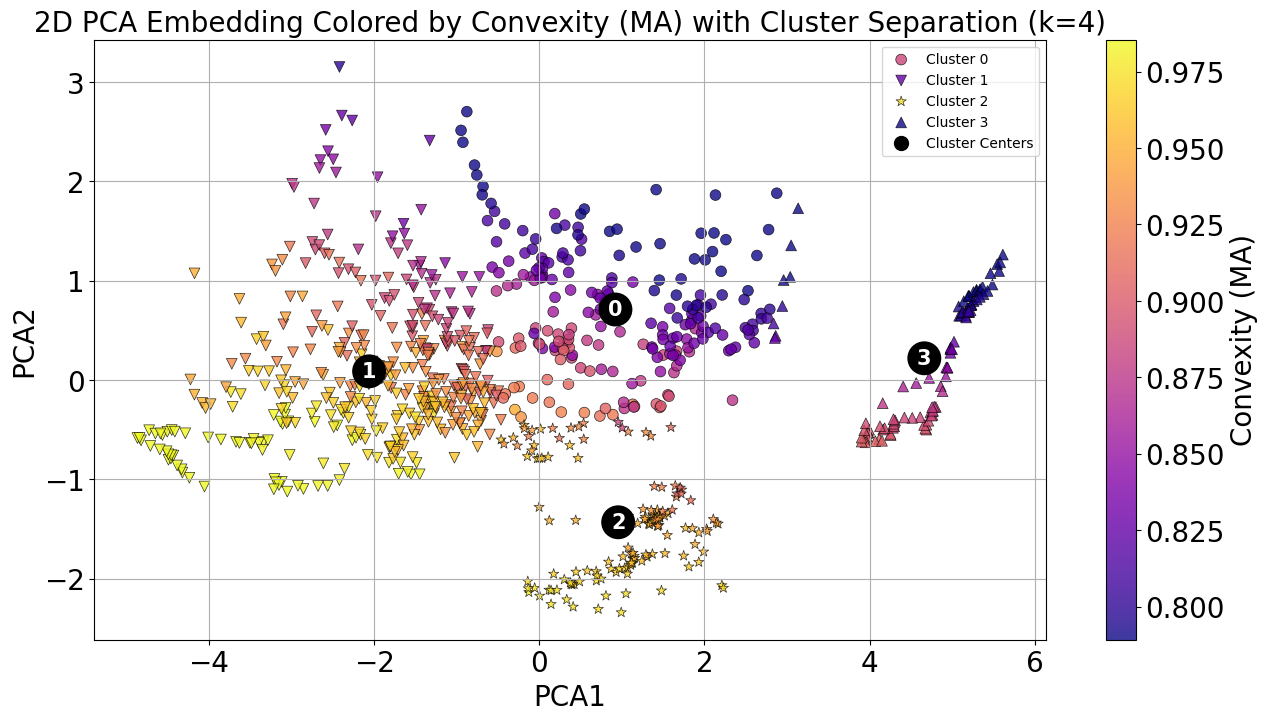

✅ PCA complete. Explained variance: [0.74190207 0.11398905 0.09666794 0.03045846 0.01010819]...
✅ Optimal K for clustering: 4
📁 Results saved: /home/MinaHossain/EmbedTrack/Track_New_Result_Shape/PCA_PHATE_Median_PLOTS_CR/PCA/PCA_Cluster_Results_5.csv
📊 Cluster summary saved: /home/MinaHossain/EmbedTrack/Track_New_Result_Shape/PCA_PHATE_Median_PLOTS_CR/PCA/PCA_Cluster_Summary_5.csv


/tmp/ipykernel_3695783/462869339.py:188: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pca_df, x="Cluster", y="Convexity_MA", palette="Set2")                                                # Change the name


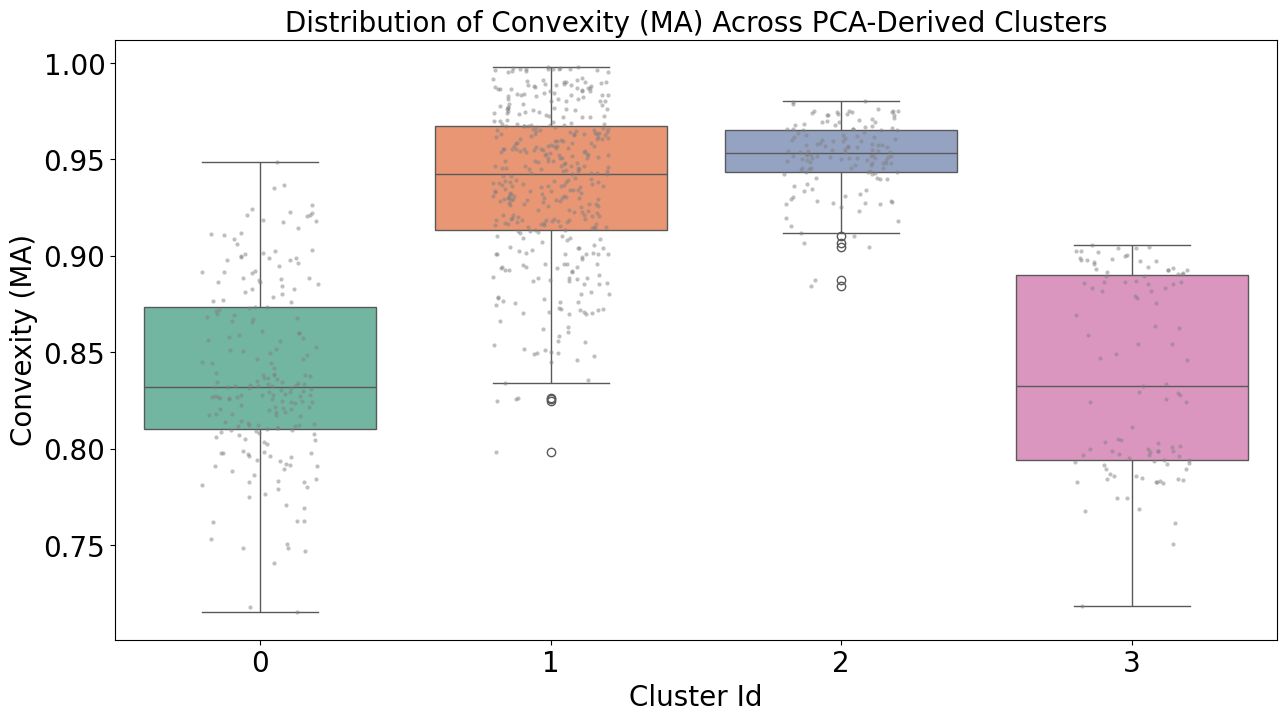

In [27]:

def apply_pca_with_clustering(csv_path, output_directory, window_size):
    # Load data
    df = pd.read_csv(csv_path)
    selected_columns = ["Cell Number", "Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA", "Compactness_MA",
                        "Elongation_MA", "Circularity_MA", "Convexity_MA", 
                        "X_Centroid_Velocity_MA", "Y_Centroid_Velocity_MA"]
    
    mini_df = df[selected_columns].copy()

    # Standardize features (excluding Cell Number and velocity)
    features_to_scale = mini_df.drop(columns=["Cell Number", "X_Centroid_Velocity_MA", "Y_Centroid_Velocity_MA"])
    X_scaled = StandardScaler().fit_transform(features_to_scale)

    # --- PCA Variance Analysis and Elbow Plot ---
    pca_full = PCA()
    pca_full.fit(X_scaled)
    explained_variance = pca_full.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    optimal_components = np.argmax(cumulative_variance >= 0.95) + 1

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='s', linestyle='-', color='red', label="Cumulative Variance")
    plt.axvline(x=optimal_components, color='green', linestyle='--', label=f"Optimal Components ({optimal_components})")
    plt.scatter(optimal_components, cumulative_variance[optimal_components-1], color='black', s=50, label="Chosen Point")
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("PCA Elbow Plot with Cumulative Variance")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, f"PCA_Elbow_Plot_{window_size}.png"))
    plt.show()

    print(f"Optimal number of PCA components selected: {optimal_components}")

    # --- Apply 2D PCA ---
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X_scaled)
    pca_df = pd.DataFrame(pca_result, columns=["PCA1", "PCA2"])
    pca_df["Cell Number"] = mini_df["Cell Number"]
    # pca_df["X_Centroid_Velocity_MA"] = mini_df["X_Centroid_Velocity_MA"]                                               # Change the Name
    pca_df["Convexity_MA"] = mini_df["Convexity_MA"]                                                                     # Change the Name

    # --- KMeans Clustering in 2D PCA Space ---
    silhouette_scores = []
    k_range = range(2,15)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(pca_df[["PCA1", "PCA2"]])
        score = silhouette_score(pca_df[["PCA1", "PCA2"]], kmeans.labels_)
        silhouette_scores.append(score)

    # ################################################################################# Plot silhouette scores vs k with annotation
    optimal_k = k_range[np.argmax(silhouette_scores)]
    optimal_score = max(silhouette_scores)

    plt.figure(figsize=(14, 8))
    plt.plot(k_range, silhouette_scores, marker='o', linestyle='-', color='purple', label="Silhouette Score")
    plt.axvline(x=optimal_k, color='green', linestyle='--', label=f"Optimal k = {optimal_k}")
    plt.scatter(optimal_k, optimal_score, color='red', s=100, zorder=5)
    plt.xlabel("Number of Clusters",fontsize=20)
    plt.ylabel("Silhouette Score",fontsize=20)
    plt.title("Silhouette Score vs Number of Clusters(PCA) ", fontsize=20)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=15)
    plt.subplots_adjust(left=0.12, right=0.95, top=0.90, bottom=0.15)
    # plt.savefig(os.path.join(output_directory, f"PCA_Silhouette_Score_vs_K_{window_size}.png"))
    plt.show()

    # --- Final Clustering ---

    optimal_kk=4 ### Number of Cluster
    kmeans = KMeans(n_clusters=optimal_kk, random_state=0, n_init='auto')
    pca_df["Cluster"] = kmeans.fit_predict(pca_df[["PCA1", "PCA2"]])
    cluster_centers = kmeans.cluster_centers_

    # --- Save PCA+Cluster Results ---
    output_csv = os.path.join(output_directory, f"PCA_Cluster_Results_{window_size}.csv")
    pca_df.to_csv(output_csv, index=False)

        

   
    ########################################################################################
    # Set limits for Perimeter_MA color scaling
    # vmin = np.percentile(pca_df["X_Centroid_Velocity_MA"], 5)                                                          # Change the name
    # vmax = np.percentile(pca_df["X_Centroid_Velocity_MA"], 95)

    vmin = np.percentile(pca_df["Convexity_MA"], 5)                                                                           # Change the name
    vmax = np.percentile(pca_df["Convexity_MA"], 95)

    plt.figure(figsize=(14, 8))

    # Choose marker shapes per cluster if few clusters
    markers = ['o', 'v', '*', "^", "H", "D", ".", 's', '^', 'D',  'P','X', '<', '>']  # Up to 14 clusters
    num_clusters = pca_df["Cluster"].nunique()

    for cluster_id in sorted(pca_df["Cluster"].unique()):
        cluster_data = pca_df[pca_df["Cluster"] == cluster_id]
        
        plt.scatter(
            cluster_data["PCA1"],
            cluster_data["PCA2"],
            # c=cluster_data["X_Centroid_Velocity_MA"],                            # Change the name
            c=cluster_data["Convexity_MA"],
            cmap="plasma",
            alpha=0.8,
            vmin=vmin,
            vmax=vmax,
            edgecolor='black',
            linewidth=0.5,
            s=60,
            marker=markers[cluster_id % len(markers)],  # Cycle through markers
            label=f"Cluster {cluster_id}"
        )

    # Colorbar to represent Perimeter_MA
    cbar = plt.colorbar()
    # cbar.set_label("X_Centroid Velocity (MA)",fontsize=20)                        # Change the name 
    cbar.ax.tick_params(labelsize=20)                                             
    cbar.set_label("Convexity (MA)", fontsize=20)                                      # Change the name
    # Cluster Centers
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
                c='black', s=100, marker='o', label='Cluster Centers',vmin=vmin, vmax=vmax)
    for idx, (x, y) in enumerate(cluster_centers):
        plt.text(x, y, f"{idx}", fontsize=15, fontweight='bold', ha='center', va='center', color='white',
                bbox=dict(facecolor='black', boxstyle='circle,pad=0.3'))
        

    # plt.title(f"2D PCA Embedding Colored by X_Centroid Velocity (MA) with Cluster Separation (k={optimal_k})",fontsize=20)                  # change the name
    plt.title(f"2D PCA Embedding Colored by Convexity (MA) with Cluster Separation (k={optimal_kk})",fontsize=20)
    plt.xlabel("PCA1",fontsize=20)
    plt.ylabel("PCA2",fontsize=20)
    # plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.subplots_adjust(left=0.12, right=0.97, top=0.90, bottom=0.15)
    plt.legend()
    # plt.legend(fontsize=20,loc='upper left'); 
    # plt.savefig(os.path.join(output_directory, f"PCA_X_Centroid_Velocity_MA_Color_ClusterSeparated_{window_size}.png"))                           # change the name
    plt.savefig(os.path.join(output_directory, f"PCA_Convexity_MA_Color_Cluster_Separated_{window_size}.png")) 
    plt.show()


    # --- Cluster Summary Statistics ---
    cluster_summary = pca_df.groupby("Cluster").agg({
        "PCA1": ["mean", "std"],
        "PCA2": ["mean", "std"],
        # "X_Centroid_Velocity_MA": ["mean", "std"],                                # Change the name
        "Convexity_MA": ["mean", "std"],
    }).reset_index()
    cluster_summary.columns = ["_".join(col).strip("_") for col in cluster_summary.columns.values]

    summary_path = os.path.join(output_directory, f"PCA_Cluster_Summary_{window_size}.csv")
    cluster_summary.to_csv(summary_path, index=False)

    print(f"✅ PCA complete. Explained variance: {explained_variance[:5]}...")
    print(f"✅ Optimal K for clustering: {optimal_kk}")
    print(f"📁 Results saved: {output_csv}")
    print(f"📊 Cluster summary saved: {summary_path}")

    

    # #########################################################################--- Seaborn Boxplot: X Centroid Velocity by Cluster ---
    # vmin = pca_df["X_Centroid_Velocity_MA"].quantile(0.05)                                 # Change the name
    # vmax = pca_df["X_Centroid_Velocity_MA"].quantile(0.95)

    vmin = pca_df["Convexity_MA"].quantile(0.05)                                           # Change the name
    vmax = pca_df["Convexity_MA"].quantile(0.95)

    plt.figure(figsize=(14, 8))
    # sns.boxplot(data=pca_df, x="Cluster", y="X_Centroid_Velocity_MA", palette="Set2")                                                # Change the name
    # sns.stripplot(data=pca_df, x="Cluster", y="X_Centroid_Velocity_MA", color='gray', alpha=0.5, jitter=0.2, size=3)                  # Change the name
    # plt.title(" Distribution of X_Centroid Velocity (MA) Across PCA-Derived Clusters ", fontsize=20)                                  # Change the name
    # plt.ylabel("X_Centroid Velocity (MA)",fontsize=20)                                                                                # Change the name
    # plt.xticks(fontsize=20)
    # plt.yticks(fontsize=20)
    
    # plt.legend(fontsize=20,loc='upper left');
    # plt.legend(fontsize=15);  
    
    sns.boxplot(data=pca_df, x="Cluster", y="Convexity_MA", palette="Set2")                                                # Change the name
    sns.stripplot(data=pca_df, x="Cluster", y="Convexity_MA", color='gray', alpha=0.5, jitter=0.2, size=3)                 # Change the name
    plt.title(" Distribution of Convexity (MA) Across PCA-Derived Clusters ", fontsize=20)                                  # Change the name
    plt.ylabel("Convexity (MA)",fontsize=20)                                                                                 # Change the name
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)                                                                                             

    plt.xlabel("Cluster Id",fontsize=20)
    plt.tight_layout()
    plt.subplots_adjust(left=0.12, right=0.95, top=0.90, bottom=0.15)
    # plt.ylim(vmin, vmax)
    # plt.ylim(-40, 40)
    # plt.savefig(os.path.join(output_directory, f"PCA_Boxplot_X_Centroid_Velocity_MA_By_Cluster_{window_size}.png"))           # Change the name
    plt.savefig(os.path.join(output_directory, f"PCA_Boxplot_Convexity_MA_By_Cluster_{window_size}.png"))
    plt.show()




# Run it
# window_size = 5
# output_directory = "/home/MinaHossain/EmbedTrack/Track_HP4_Result_Shape/PCA_PHATE_Median_PLOTS_CR/PCA"
# input_directory = "/home/MinaHossain/EmbedTrack/Track_HP4_Result_Shape/Median"
# csv_path = os.path.join(input_directory, f"Cells_Centroid_Velocity_TrueLabel_MA_Median_{window_size}.csv")
# apply_pca_with_clustering(csv_path, output_directory, window_size)


window_size = 5
output_directory = "/home/MinaHossain/EmbedTrack/Track_New_Result_Shape/PCA_PHATE_Median_PLOTS_CR/PCA"

input_directory= "/home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Mean"

csv_path = os.path.join(input_directory, f"Cells_Centroid_Velocity_TrueLabel_MA_Mean_{window_size}.csv")
apply_pca_with_clustering(csv_path, output_directory, window_size)


# mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/Track_New"
# output_directory = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/Track_New_Output"

# # Optionally, color by another feature
# color_by_feature(phate_results, "X_Centroid_Velocity_MA", output_directory, window_size)


# ["Cell Number", "Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA", "Compactness_MA","Elongation_MA", "Circularity_MA", "Convexity_MA", "X_Centroid_Velocity_MA", "Y_Centroid_Velocity_MA"]



# LATEST Phate Analysis, Cluster , Boxplot

Optimal PCA components to retain 95% variance: 3
PCA Variance Explained: 0.9554
Calculating PHATE...
  Running PHATE on 694 observations and 3 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.03 seconds.
  Calculating optimal t...


    Automatically selected t = 21
  Calculated optimal t in 0.17 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.02 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.35 seconds.
Calculated PHATE in 0.57 seconds.
Optimal number of clusters based on silhouette score: k=2, score=0.7956


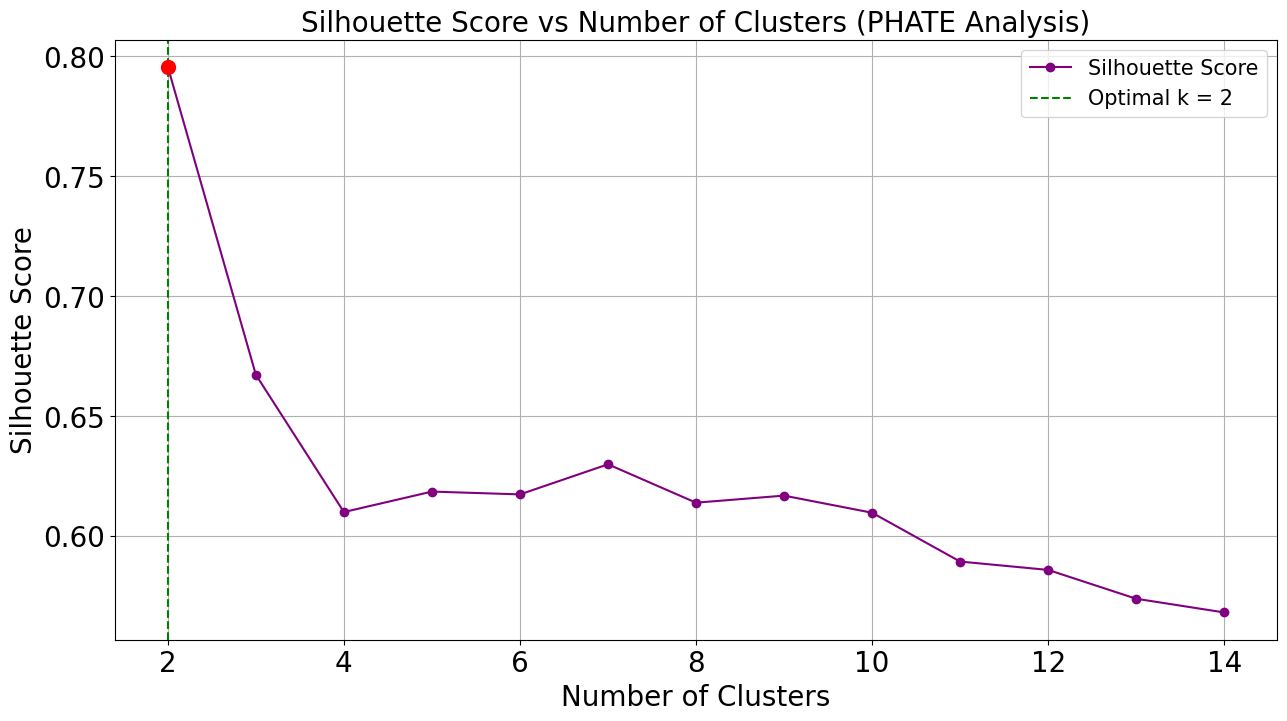

/tmp/ipykernel_3695783/2959070601.py:133: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1],


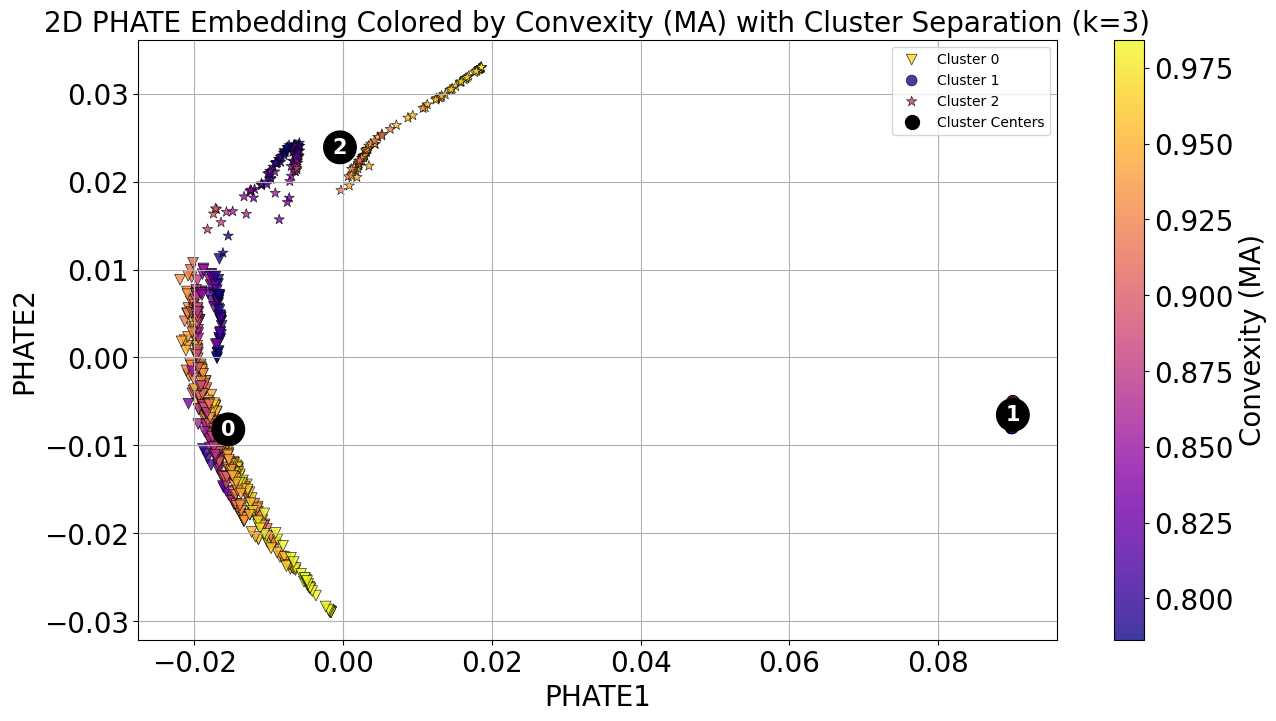

/tmp/ipykernel_3695783/2959070601.py:180: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=phate_df, x="Cluster", y="Convexity_MA", palette="Set2")                                     # Change the name


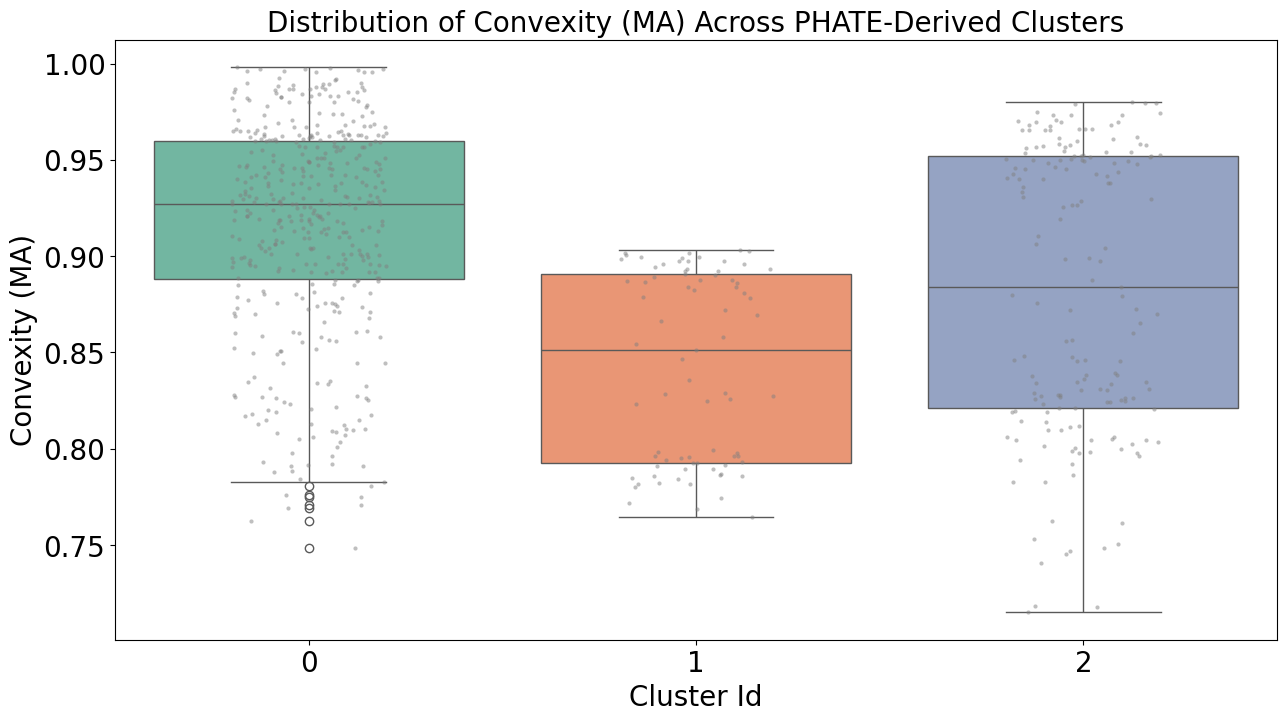

     PHATE1    PHATE2  Cell Number  Convexity_MA  Cluster
0 -0.011416 -0.020667            2      0.967665        0
1 -0.011374 -0.020671            2      0.961058        0
2 -0.014107 -0.017362            2      0.899169        0
3 -0.013364 -0.018444            2      0.910156        0
4 -0.013480 -0.018362            2      0.909591        0
5 -0.014166 -0.017195            2      0.895761        0
6 -0.014370 -0.016915            2      0.888437        0
7 -0.014804 -0.015910            2      0.894175        0
8 -0.016390 -0.013456            2      0.872881        0
9 -0.016584 -0.012615            2      0.881034        0
Best cluster count (k): 3


In [40]:

def apply_phate(csv_path, output_directory, window_size, variance_threshold=0.95):
    """Apply PCA + PHATE + dynamic KMeans clustering with optimal k selection using silhouette scores."""

    # Load data
    df = pd.read_csv(csv_path)

    # Select relevant columns
    selected_columns = [
        "Cell Number", "Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA",
        "Compactness_MA", "Elongation_MA", "Circularity_MA", "Convexity_MA",
        "X_Centroid_Velocity_MA", "Y_Centroid_Velocity_MA"
    ]
    mini_df = df[selected_columns].copy()

    # Drop 'Cell Number' and velocities for PCA features
    feature_cols = mini_df.drop(columns=["Cell Number", "X_Centroid_Velocity_MA", "Y_Centroid_Velocity_MA"]).columns.tolist()

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(mini_df[feature_cols])

    # Apply PCA for variance explanation
    pca = PCA()
    pca.fit(X_scaled)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    optimal_components = np.argmax(cumulative_variance >= variance_threshold) + 1

    print(f"Optimal PCA components to retain {variance_threshold * 100:.0f}% variance: {optimal_components}")

    # Apply PCA with optimal components
    pca = PCA(n_components=optimal_components)   ########################### 2
    X_pca = pca.fit_transform(X_scaled)
    print(f"PCA Variance Explained: {np.sum(pca.explained_variance_ratio_):.4f}")

    # Apply PHATE
    phate_operator = phate.PHATE(n_components=2, knn=30, random_state=42)
    X_phate = phate_operator.fit_transform(X_pca)

    # Determine optimal k using silhouette score
    silhouette_scores = []
    k_range = range(2, 15)
    for k in k_range:
        kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(X_phate)
        score = silhouette_score(X_phate, kmeans_temp.labels_)
        silhouette_scores.append(score)

    optimal_k = k_range[np.argmax(silhouette_scores)]
    optimal_score = max(silhouette_scores)
    print(f"Optimal number of clusters based on silhouette score: k={optimal_k}, score={optimal_score:.4f}")

    ####################################################################  Plot silhouette scores
    plt.figure(figsize=(14, 8))
    plt.plot(k_range, silhouette_scores, marker='o', linestyle='-', color='purple', label="Silhouette Score")
    plt.axvline(x=optimal_k, color='green', linestyle='--', label=f"Optimal k = {optimal_k}")
    plt.scatter(optimal_k, optimal_score, color='red', s=100, zorder=5)
   
    plt.title("Silhouette Score vs Number of Clusters (PHATE Analysis)",fontsize=20)
    plt.xlabel("Number of Clusters",fontsize=20)
    plt.ylabel("Silhouette Score",fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=15)
    # plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.subplots_adjust(left=0.12, right=0.95, top=0.90, bottom=0.15)
    # plt.savefig(os.path.join(output_directory, f"PHATE_Silhouette_Scores_{window_size}.png"))
    plt.show()

    # Apply k-means with optimal k

    optimal_kk=3

    kmeans = KMeans(n_clusters=optimal_kk, random_state=44, n_init='auto')
    clusters = kmeans.fit_predict(X_phate)
    cluster_centers = kmeans.cluster_centers_

    # Save PHATE results
    phate_df = pd.DataFrame(X_phate, columns=["PHATE1", "PHATE2"])
    phate_df["Cell Number"] = mini_df["Cell Number"]
    # phate_df["X_Centroid_Velocity_MA"] = mini_df["X_Centroid_Velocity_MA"]                # Change the  name
    phate_df["Convexity_MA"] = mini_df["Convexity_MA"]                                      # Change the name
    phate_df["Cluster"] = clusters

 


    # Save to CSV
    phate_df.to_csv(os.path.join(output_directory, f"PHATE_Embedding_Clustered_{window_size}.csv"), index=False)



    ##############################################################  Set limits for Perimeter_MA color scaling
    # vmin = np.percentile(phate_df["X_Centroid_Velocity_MA"], 5)                                         # Change the name
    # vmax = np.percentile(phate_df["X_Centroid_Velocity_MA"], 95)                                        # Change the name

    vmin = np.percentile(phate_df["Convexity_MA"], 5)                                         # Change the name
    vmax = np.percentile(phate_df["Convexity_MA"], 95)                                        # Change the name

    plt.figure(figsize=(14, 8))

    # Choose marker shapes per cluster if few clusters
    markers = ['v', 'o', '*', "^", "H", "D", ".", 's', '^', 'D',  'P','X', '<', '>']  # Up to 14 clusters
    num_clusters = phate_df["Cluster"].nunique()

    for cluster_id in sorted(phate_df["Cluster"].unique()):
        cluster_data = phate_df[phate_df["Cluster"] == cluster_id]
        
        plt.scatter(
            cluster_data["PHATE1"],
            cluster_data["PHATE2"],
            # c=cluster_data["X_Centroid_Velocity_MA"],                     # Change the name
            c=cluster_data["Convexity_MA"],                                    # Change the name
            cmap="plasma",
            alpha=0.8,
            vmin=vmin,
            vmax=vmax,
            edgecolor='black',
            linewidth=0.5,
            s=60,
            marker=markers[cluster_id % len(markers)],  # Cycle through markers
            label=f"Cluster {cluster_id}"
        )

    # Colorbar to represent Perimeter_MA
    cbar = plt.colorbar()
    # cbar.set_label("X_Centroid Velocity (MA)",fontsize=20)                                           # Change the name
    cbar.set_label("Convexity (MA)",fontsize=20)                                                             # change the name  
    cbar.ax.tick_params(labelsize=20)
    

    # Cluster Centers
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
                c='black', s=100, marker='o', label='Cluster Centers',vmin=vmin, vmax=vmax)
    for idx, (x, y) in enumerate(cluster_centers):
        plt.text(x, y, f"{idx}", fontsize=15, fontweight='bold', ha='center', va='center', color='white',
                bbox=dict(facecolor='black', boxstyle='circle,pad=0.3'))

    
    # plt.title(f"2D PHATE Embedding Colored by X_Centroid Velocity (MA) with Cluster Separation (k={optimal_k})",fontsize=20)          # change the name
    plt.title(f"2D PHATE Embedding Colored by Convexity (MA) with Cluster Separation (k={optimal_kk})",fontsize=20)                         # change the name
    
    plt.xlabel("PHATE1", fontsize=20)
    plt.ylabel("PHATE2",fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.subplots_adjust(left=0.15, right=0.97, top=0.90, bottom=0.15)
    
    # plt.legend()
    # plt.savefig(os.path.join(output_directory, f"PHATE_X_Centroid_Velocity_MA_Color_ClusterSeparated_{window_size}.png"))         # change the name
    plt.savefig(os.path.join(output_directory, f"PHATE_Convexity_MA_Color_Cluster_Separated_{window_size}.png"))                         # change the name
    plt.show()




       

    # --- Seaborn Boxplot: X Centroid Velocity by Cluster ---
    # vmin = phate_df["X_Centroid_Velocity_MA"].quantile(0.05)            # Change the name
    # vmax = phate_df["X_Centroid_Velocity_MA"].quantile(0.99)            # Change the name

    vmin = phate_df["Convexity_MA"].quantile(0.05)            # Change the name
    vmax = phate_df["Convexity_MA"].quantile(0.99)            # Change the name


    plt.figure(figsize=(14, 8))
    # sns.boxplot(data=phate_df, x="Cluster", y="X_Centroid_Velocity_MA", palette="Set2")                                     # Change the name
    # sns.stripplot(data=phate_df, x="Cluster", y="X_Centroid_Velocity_MA", color='gray', alpha=0.5, jitter=0.2, size=3)      # Change the name
    # plt.title("Distribution of X_Centroid Velocity (MA) Across PHATE-Derived Clusters", fontsize=20)                                      # Change the name
    # plt.ylabel("X_Centroid Velocity (MA)",fontsize=20)                                                                                    # Change the name
    # plt.xlabel("Cluster Id",fontsize=20)
    # plt.xticks(fontsize=20)
    # plt.yticks(fontsize=20)
    # plt.legend()

    sns.boxplot(data=phate_df, x="Cluster", y="Convexity_MA", palette="Set2")                                     # Change the name
    sns.stripplot(data=phate_df, x="Cluster", y="Convexity_MA", color='gray', alpha=0.5, jitter=0.2, size=3)      # Change the name
    plt.title("Distribution of Convexity (MA) Across PHATE-Derived Clusters", fontsize=20)                                      # Change the name
    plt.ylabel("Convexity (MA)",fontsize=20)                                                                                    # Change the name
    plt.xlabel("Cluster Id",fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)


    # plt.xlabel("Cluster")
    plt.tight_layout()
    # plt.ylim(vmin, vmax)

    plt.subplots_adjust(left=0.12, right=0.95, top=0.90, bottom=0.15)
    # plt.savefig(os.path.join(output_directory, f"PHATE_Boxplot_X_Centroid_Velocity_MA_By_Cluster_{window_size}.png"))               # Change the name
    plt.savefig(os.path.join(output_directory, f"PHATE_Boxplot_Convexity_MA_By_Cluster_{window_size}.png"))               # Change the name
    plt.show()

    return phate_df, optimal_kk






# window_size = 5
# output_directory = "/home/MinaHossain/EmbedTrack/Track_HP4_Result_Shape/PCA_PHATE_Median_PLOTS_CR/PHATE"
# input_directory = "/home/MinaHossain/EmbedTrack/Track_HP4_Result_Shape/Median"
# csv_path = os.path.join(input_directory, f"Cells_Centroid_Velocity_TrueLabel_MA_Median_{window_size}.csv")

# phate_results, best_k = apply_phate(csv_path, output_directory, window_size)



window_size = 5
output_directory = "/home/MinaHossain/EmbedTrack/Track_New_Result_Shape/PCA_PHATE_Median_PLOTS_CR/PHATE"

input_directory= "/home/MinaHossain/EmbedTrack/Track_New_Result_Shape/Median"

csv_path = os.path.join(input_directory, f"Cells_Centroid_Velocity_TrueLabel_MA_Median_{window_size}.csv")
phate_results, best_k = apply_phate(csv_path, output_directory, window_size)

print(phate_results.head(10))
print(f"Best cluster count (k): {best_k}")

# mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/Track_New"
# output_directory = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/Track_New_Output"

# # Optionally, color by another feature
# color_by_feature(phate_results, "X_Centroid_Velocity_MA", output_directory, window_size)
